In [117]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn import svm
import xgboost as xgb
from imblearn.over_sampling import SMOTE, RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from collections import Counter
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.metrics import classification_report, confusion_matrix
import shap

In [3]:
bbdata = pd.read_csv('../Data/baseball.csv')

## EDA

In [4]:
bbdata.head()

,Team,League,Year,RS,RA,W,OBP,SLG,BA,Playoffs,RankSeason,RankPlayoffs,G,OOBP,OSLG
0,ARI,NL,2012,734,688,81,0.328,0.418,0.259,0,NaN,NaN,162,0.317,0.415
1,ATL,NL,2012,700,600,94,0.320,0.389,0.247,1,4.0,5.0,162,0.306,0.378
2,BAL,AL,2012,712,705,93,0.311,0.417,0.247,1,5.0,4.0,162,0.315,0.403
3,BOS,AL,2012,734,806,69,0.315,0.415,0.260,0,NaN,NaN,162,0.331,0.428
4,CHC,NL,2012,613,759,61,0.302,0.378,0.240,0,NaN,NaN,162,0.335,0.424


In [5]:
bbdata.describe()

,Year,RS,RA,W,OBP,SLG,BA,Playoffs,RankSeason,RankPlayoffs,G,OOBP,OSLG
count,1232.000000,1232.000000,1232.000000,1232.000000,1232.000000,1232.000000,1232.000000,1232.000000,244.000000,244.000000,1232.000000,420.000000,420.000000
mean,1988.957792,715.081981,715.081981,80.904221,0.326331,0.397342,0.259273,0.198052,3.122951,2.717213,161.918831,0.332264,0.419743
std,14.819625,91.534294,93.079933,11.458139,0.015013,0.033267,0.012907,0.398693,1.738349,1.095234,0.624365,0.015295,0.026510
min,1962.000000,463.000000,472.000000,40.000000,0.277000,0.301000,0.214000,0.000000,1.000000,1.000000,158.000000,0.294000,0.346000
25%,1976.750000,652.000000,649.750000,73.000000,0.317000,0.375000,0.251000,0.000000,2.000000,2.000000,162.000000,0.321000,0.401000
50%,1989.000000,711.000000,709.000000,81.000000,0.326000,0.396000,0.260000,0.000000,3.000000,3.000000,162.000000,0.331000,0.419000
75%,2002.000000,775.000000,774.250000,89.000000,0.337000,0.421000,0.268000,0.000000,4.000000,4.000000,162.000000,0.343000,0.438000
max,2012.000000,1009.000000,1103.000000,116.000000,0.373000,0.491000,0.294000,1.000000,8.000000,5.000000,165.000000,0.384000,0.499000


In [6]:
bbdata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1232 entries, 0 to 1231
Data columns (total 15 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Team          1232 non-null   object 
 1   League        1232 non-null   object 
 2   Year          1232 non-null   int64  
 3   RS            1232 non-null   int64  
 4   RA            1232 non-null   int64  
 5   W             1232 non-null   int64  
 6   OBP           1232 non-null   float64
 7   SLG           1232 non-null   float64
 8   BA            1232 non-null   float64
 9   Playoffs      1232 non-null   int64  
 10  RankSeason    244 non-null    float64
 11  RankPlayoffs  244 non-null    float64
 12  G             1232 non-null   int64  
 13  OOBP          420 non-null    float64
 14  OSLG          420 non-null    float64
dtypes: float64(7), int64(6), object(2)
memory usage: 144.5+ KB


In [7]:
bbdata.columns[bbdata.isna().any()].tolist()

['RankSeason', 'RankPlayoffs', 'OOBP', 'OSLG']

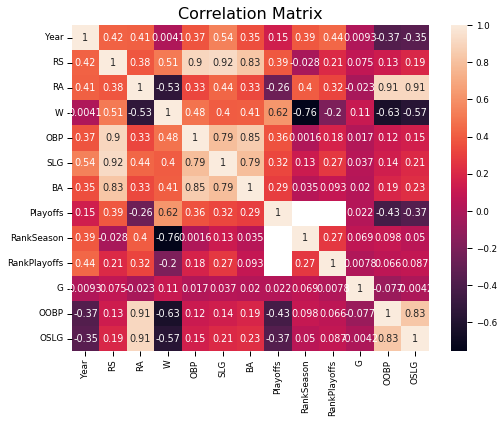

In [15]:
plt.figure(figsize=(8,6))
sns.set_context(rc={"figure.figsize":(8,6)})
sns.heatmap(bbdata.corr(), annot=True)
plt.title('Correlation Matrix',fontsize=16)
plt.show()

Based on the correlation plot, RankSeason and RankPlayoffs are highly correlated to our response variable Playoffs. This makes sense as the chances that a team makes it to the playoffs should be reflected by their rank during the season, and their rank in playoffs are only recorded if they make it to the playoffs. In this case we'll go ahead and remove those variables to avoid any influences on the predictability.

In [16]:
bbdata.drop(['RankSeason','RankPlayoffs'], axis=1, inplace=True)

In [17]:
bbdata.head()

,Team,League,Year,RS,RA,W,OBP,SLG,BA,Playoffs,G,OOBP,OSLG
0,ARI,NL,2012,734,688,81,0.328,0.418,0.259,0,162,0.317,0.415
1,ATL,NL,2012,700,600,94,0.320,0.389,0.247,1,162,0.306,0.378
2,BAL,AL,2012,712,705,93,0.311,0.417,0.247,1,162,0.315,0.403
3,BOS,AL,2012,734,806,69,0.315,0.415,0.260,0,162,0.331,0.428
4,CHC,NL,2012,613,759,61,0.302,0.378,0.240,0,162,0.335,0.424


In [19]:
year_oobp = pd.crosstab(bbdata['Year'], bbdata['OOBP'].isna())
year_oobp.columns = ['No NA', 'Has NA']
year_oobp

,No NA,Has NA
Year,,
1962,0,20
1963,0,20
1964,0,20
1965,0,20
1966,0,20
1967,0,20
1968,0,20
1969,0,24
1970,0,24


In [20]:
year_oslg = pd.crosstab(bbdata['Year'], bbdata['OSLG'].isna())
year_oslg.columns = ['No NA', 'Has NA']
year_oslg

,No NA,Has NA
Year,,
1962,0,20
1963,0,20
1964,0,20
1965,0,20
1966,0,20
1967,0,20
1968,0,20
1969,0,24
1970,0,24


In [21]:
bbdata[['OOBP', 'OSLG']].describe()

,OOBP,OSLG
count,420.000000,420.000000
mean,0.332264,0.419743
std,0.015295,0.026510
min,0.294000,0.346000
25%,0.321000,0.401000
50%,0.331000,0.419000
75%,0.343000,0.438000
max,0.384000,0.499000


array([<AxesSubplot:title={'center':'OSLG'}>], dtype=object)

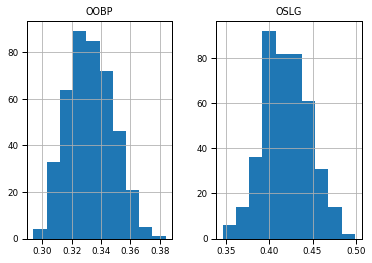

In [22]:
fig, axes = plt.subplots(1,2)
bbdata.hist('OOBP', ax=axes[0])
bbdata.hist('OSLG', ax=axes[1])

It seems that they did not record OOBP and OSLG before 1999 and this could be due to technology not being as advanced now to record these statistics. Since the median and mean seem to be approximately the same for these columns, indicating that these distributions are not skewed, we can replace the null values with the mean values for these columns.

In [23]:
mean_oobp = bbdata['OOBP'].mean()
mean_oslg = bbdata['OSLG'].mean()
bbdata['OOBP'].fillna(value=mean_oobp, inplace=True)
bbdata['OSLG'].fillna(value=mean_oslg, inplace=True)

In [25]:
bbdata.columns[bbdata.isna().any()].tolist()

[]

## Feature Engineering

In [26]:
# Win percentage
# Encoding for Year, League, Team
# Class imbalance
# OBP + SLG = OPS same with OOBP and OSLG -- can drop the original columns after

In [27]:
def clean_data(df):
    df['OPS'] = df['OBP'] + df['SLG']
    df['OOPS'] = df['OOBP'] + df['OSLG']
    df['W_PCT'] = df['W']/df['G']

    # One hot encoding
    onehotencoder = OneHotEncoder()
    onehotencoder_df = pd.DataFrame(onehotencoder.fit_transform(df[['Team', 'League']]).toarray())
    onehotencoder_df.columns = onehotencoder.get_feature_names_out(['Team', 'League'])
    ordencoder = OrdinalEncoder()
    ordencoder_df = pd.DataFrame(ordencoder.fit_transform(df[['Year']]))
    df = df.join(onehotencoder_df)
    df['Year'] = ordencoder_df
    df = df.drop(columns=['OBP', 'SLG', 'OOBP','OSLG','W', 'G','Team', 'League'])
    return df

In [28]:
bbdata = clean_data(bbdata)

In [29]:
bbdata

,Year,RS,RA,BA,Playoffs,OPS,OOPS,W_PCT,Team_ANA,Team_ARI,...,Team_SFG,Team_STL,Team_TBD,Team_TBR,Team_TEX,Team_TOR,Team_WSA,Team_WSN,League_AL,League_NL
0,46.0,734,688,0.259,0,0.746,0.732000,0.500000,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,46.0,700,600,0.247,1,0.709,0.684000,0.580247,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,46.0,712,705,0.247,1,0.728,0.718000,0.574074,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,46.0,734,806,0.260,0,0.730,0.759000,0.425926,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,46.0,613,759,0.240,0,0.680,0.759000,0.376543,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1227,0.0,705,759,0.260,0,0.720,0.752007,0.503106,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1228,0.0,706,626,0.268,0,0.715,0.752007,0.577640,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1229,0.0,878,690,0.278,1,0.782,0.752007,0.624242,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1230,0.0,774,664,0.271,0,0.729,0.752007,0.515337,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [76]:
X = bbdata.drop(['Playoffs'], axis=1)
y = bbdata['Playoffs']

In [77]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
print('X training data: ', X_train.shape, '; ', 'y training data: ', y_train.shape,'; ', 'X testing data: ', X_test.shape,'; ', 'y testing data: ', y_test.shape)

X training data:  (985, 48) ;  y training data:  (985,) ;  X testing data:  (247, 48) ;  y testing data:  (247,)


In [78]:
# Class imbalance
bbdata['Playoffs'].value_counts()

0    988
1    244
Name: Playoffs, dtype: int64

In [79]:
# Rebalancing only training data to avoid artificially boosted model scores
counter = Counter(y_train)
print('Before', counter)
over = SMOTE(sampling_strategy=0.5) # oversample minority class to have 50 percent the number of ex of majority class
under = RandomUnderSampler(sampling_strategy=0.5) # reduce the number of examples majority class to have 50 percent more than the minority class
steps = [('o', over), ('u', under)]
pipeline = Pipeline(steps=steps)
X_train, y_train = pipeline.fit_resample(X_train, y_train)
counter = Counter(y_train)
print('After', counter)

Before Counter({0: 798, 1: 187})
After Counter({0: 798, 1: 399})


In [105]:
model = Sequential()
model.add(Dense(48, input_shape=(48,), activation = 'relu'))
model.add(Dense(24, activation = 'relu'))
model.add(Dense(1, activation = 'sigmoid'))
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_11 (Dense)            (None, 48)                2352      
                                                                 
 dense_12 (Dense)            (None, 24)                1176      
                                                                 
 dense_13 (Dense)            (None, 1)                 25        
                                                                 
Total params: 3,553
Trainable params: 3,553
Non-trainable params: 0
_________________________________________________________________


In [106]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3, restore_best_weights=True)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(X_train, y_train, epochs=10, callbacks=[callback], validation_data=(X_test, y_test))

Epoch 1/10
38/38 [==============================] - 1s 7ms/step - loss: 1.5085 - accuracy: 0.7151 - val_loss: 0.6631 - val_accuracy: 0.8462
Epoch 2/10
38/38 [==============================] - 0s 2ms/step - loss: 0.4928 - accuracy: 0.8354 - val_loss: 0.6484 - val_accuracy: 0.8138
Epoch 3/10
38/38 [==============================] - 0s 2ms/step - loss: 0.3928 - accuracy: 0.8505 - val_loss: 0.4498 - val_accuracy: 0.8502
Epoch 4/10
38/38 [==============================] - 0s 2ms/step - loss: 0.5719 - accuracy: 0.8087 - val_loss: 0.3596 - val_accuracy: 0.8704
Epoch 5/10
38/38 [==============================] - 0s 2ms/step - loss: 0.3492 - accuracy: 0.8622 - val_loss: 0.3049 - val_accuracy: 0.8745
Epoch 6/10
38/38 [==============================] - 0s 2ms/step - loss: 0.3446 - accuracy: 0.8563 - val_loss: 0.2779 - val_accuracy: 0.8826
Epoch 7/10
38/38 [==============================] - 0s 2ms/step - loss: 0.3267 - accuracy: 0.8571 - val_loss: 0.3547 - val_accuracy: 0.8381
Epoch 8/10
38/38 [==

In [107]:
model.evaluate(X_test, y_test)

8/8 [==============================] - 0s 1ms/step - loss: 0.2968 - accuracy: 0.8704


[0.2968140244483948, 0.8704453706741333]

In [108]:
y_pred = np.argmax(model.predict(X_test), axis=-1)
print(classification_report(y_test.tolist(), y_pred))

8/8 [==============================] - 0s 1ms/step
              precision    recall  f1-score   support

           0       0.77      1.00      0.87       190
           1       0.00      0.00      0.00        57

    accuracy                           0.77       247
   macro avg       0.38      0.50      0.43       247
weighted avg       0.59      0.77      0.67       247



/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

In [93]:
# Logistic Regression
logit_model = LogisticRegression(solver='lbfgs', random_state=0)
logit_model.fit(X_train, y_train)
y_pred_logit = logit_model.predict(X_test)
print(confusion_matrix(y_test, y_pred_logit))
print(classification_report(y_test, y_pred_logit))

[[173  17]
 [ 11  46]]
              precision    recall  f1-score   support

           0       0.94      0.91      0.93       190
           1       0.73      0.81      0.77        57

    accuracy                           0.89       247
   macro avg       0.84      0.86      0.85       247
weighted avg       0.89      0.89      0.89       247



/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [114]:
# XGBoost
xgb_model = xgb.XGBClassifier(random_state=0)
xgb_model.fit(X_train, y_train)
y_pred_xgb = xgb_model.predict(X_test)
print(confusion_matrix(y_test, y_pred_xgb))
print(classification_report(y_test, y_pred_xgb))

[[178  12]
 [  9  48]]
              precision    recall  f1-score   support

           0       0.95      0.94      0.94       190
           1       0.80      0.84      0.82        57

    accuracy                           0.91       247
   macro avg       0.88      0.89      0.88       247
weighted avg       0.92      0.91      0.92       247



In [110]:
# SVM
svm_model = svm.SVC()
svm_model.fit(X_train, y_train)
y_pred_svm = svm_model.predict(X_test)
print(confusion_matrix(y_test, y_pred_svm))
print(classification_report(y_test, y_pred_svm))

[[174  16]
 [ 15  42]]
              precision    recall  f1-score   support

           0       0.92      0.92      0.92       190
           1       0.72      0.74      0.73        57

    accuracy                           0.87       247
   macro avg       0.82      0.83      0.82       247
weighted avg       0.88      0.87      0.87       247



In [115]:
# A parameter grid for XGBoost
params = {
        'eta': [0.01,0.3, 0.5],
        'gamma': [0.5, 1, 2, 5],
        'subsample': [0.6, 0.8, 1.0],
        'max_depth': [3, 4, 6]
        }

xgb_model_gs = GridSearchCV(xgb_model, param_grid=params, cv = 5, scoring="accuracy", n_jobs=-1)
xgb_model_gs.fit(X_train, y_train)
print(xgb_model_gs.best_params_)
# best parameters: eta:0.01, gamma:0.5, max_depth:6, subsample:0.6

{'eta': 0.01, 'gamma': 0.5, 'max_depth': 6, 'subsample': 0.6}


In [116]:
xgb_model_best = xgb.XGBClassifier(random_state=0, max_depth=6, eta=0.01, gamma=0.5, subsample=0.6)
xgb_model_best.fit(X_train, y_train)
y_pred_xgb_best = xgb_model_best.predict(X_test)
print(confusion_matrix(y_test, y_pred_xgb_best))
print(classification_report(y_test, y_pred_xgb_best))

[[175  15]
 [  5  52]]
              precision    recall  f1-score   support

           0       0.97      0.92      0.95       190
           1       0.78      0.91      0.84        57

    accuracy                           0.92       247
   macro avg       0.87      0.92      0.89       247
weighted avg       0.93      0.92      0.92       247



In [119]:
# SHAP
explainer = shap.TreeExplainer(xgb_model_best)
shap_vals = explainer.shap_values(X_train)

In [120]:
shap_vals.shape

(1197, 48)

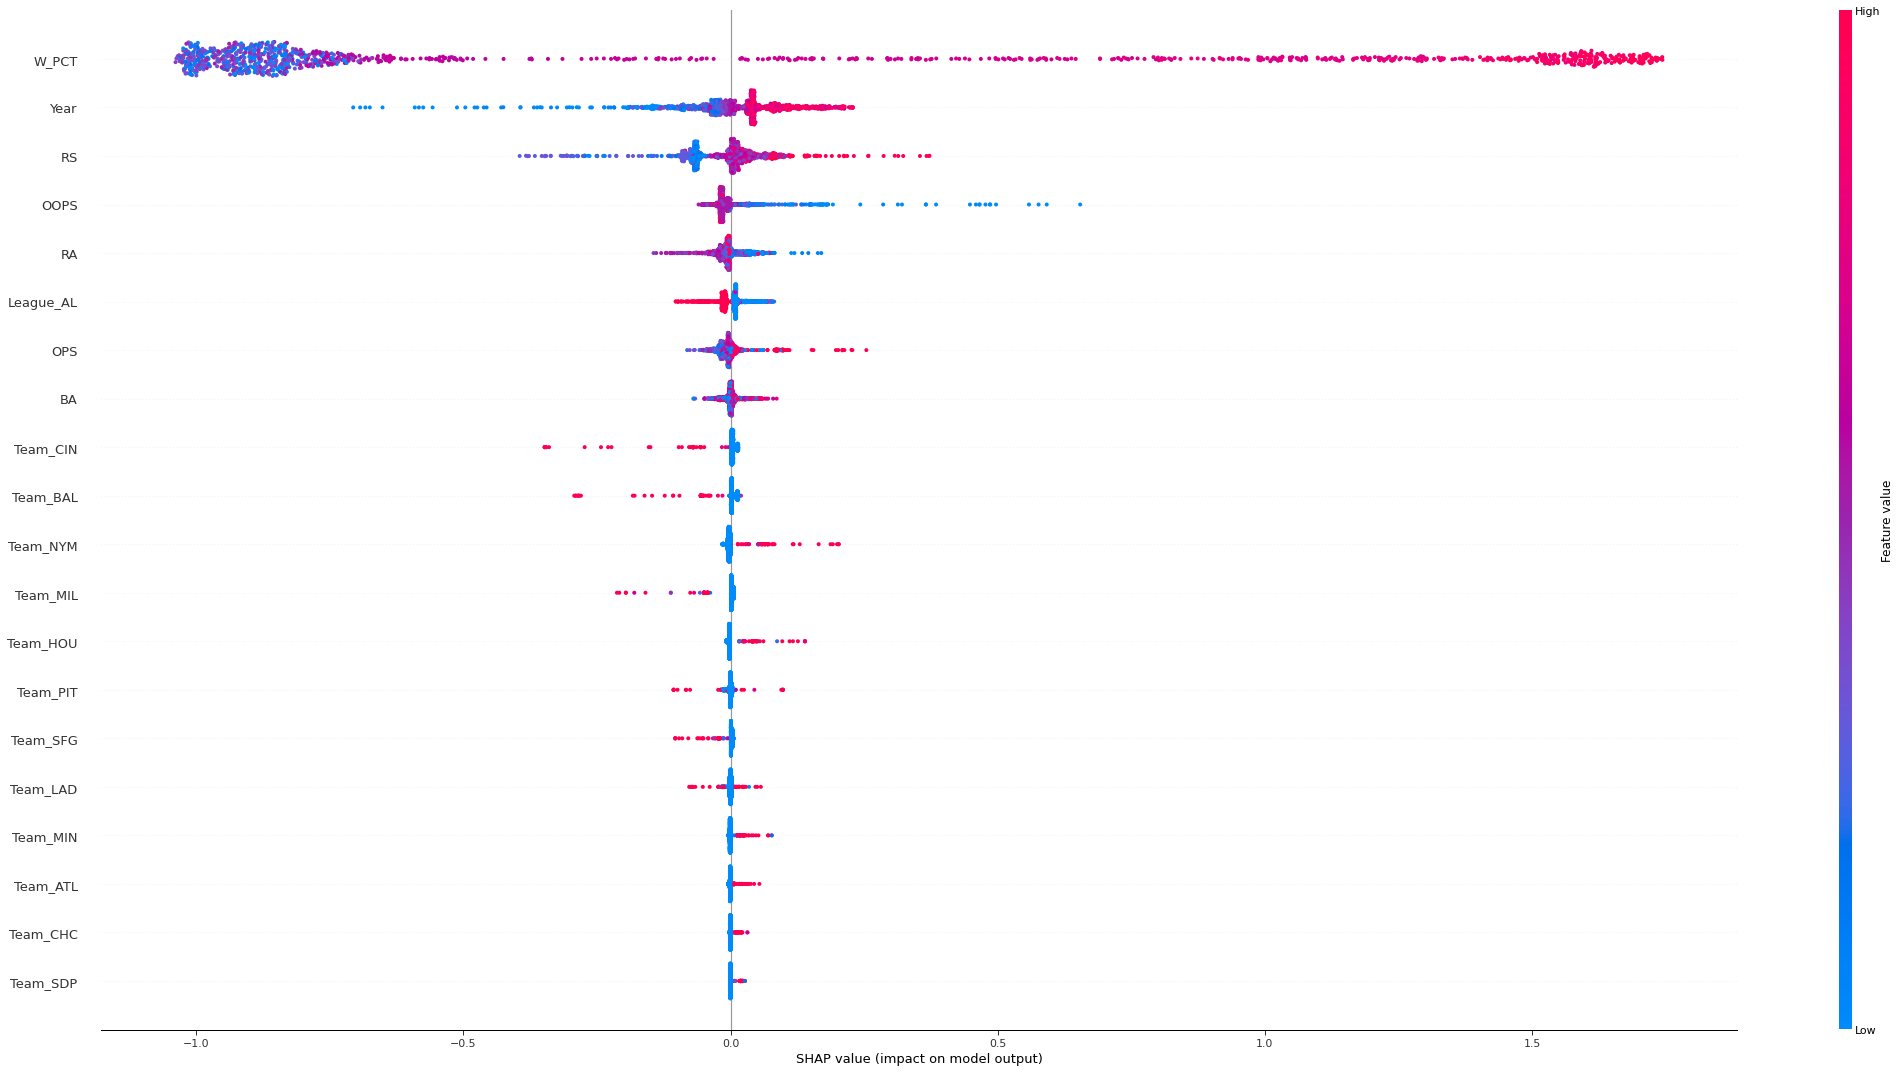

In [122]:
# show=False (Set to false to output to folder)
plt_shap = shap.summary_plot(shap_vals, features=X_train, feature_names=X_train.columns, show=False, plot_size=(30,15))
plt.savefig("shap.png")
plt.show()

The variables are ranked from top to bottom by their mean SHAP values for the entire dataset. We can see that for higher values of win percentage, the SHAP values are higher, indicating that if a team has a higher winning percentage, then they are more likely to make it to the playoffs. With the cluster of low win percentage resulting in negative SHAP values, suggests that having a low win percentage has a strong negative impact on a team making it to the playoffs.